In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


In [2]:
def mean_filter(data, number_of_points, step=1):
    
    ''' Entrada: Vetor de dados que serão filtrados = data(n,1) '''
    ''' Saída: Vetor de dados filtrados = mean_feature(n,1)'''
    mean_feature = []
    for i in range(0, number_of_points):
        mean_feature.append(np.mean(data[0: i+1]))
    if number_of_points > 1:
        for i in range(0, len(data) - number_of_points, step):
            mean_feature.append(
                np.mean(data[i: number_of_points + i]))
    else:
        return data
    return np.array(mean_feature)

In [3]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [107]:
''' Alterar o número do Voluntário e a Chave de Repetição'''

voluntary = 23
key = 'S1_Synched'

voluntary = str(voluntary)


''' Alterar o número do Voluntário Referência e a Chave de Repetição Referência'''

ref_voluntary = 1 
ref_key = 'S1_Synched'

ref_voluntary = str(ref_voluntary)


In [108]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

### Separando os dados de aceleração para cada sensor

'Hip' 'RightUpLeg' 'LeftUpLeg' 'Head' 'Neck' 'Spine3' 'Spine2' 'Spine1' 'Spine'

In [109]:
Hip = data.iloc[:,0:3].values
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Head = data.iloc[:,9:12].values
Neck = data.iloc[:,12:15].values
Spine3 = data.iloc[:,15:18].values
Spine2 = data.iloc[:,18:21].values
Spine1 = data.iloc[:,21:24].values
Spine = data.iloc[:,24:27].values

In [110]:
# Definindo a frequência de amostragem
freq_amostragem = 120


''' Alterar janela do filtro '''
window_size_s = 0.1


# Definindo o número de amostras a serem filtrados
number_of_points = int(round(freq_amostragem * window_size_s))



In [111]:
# Filtrar os dados de aceleração das IMUs
RightUpLeg_mean = np.zeros(RightUpLeg.shape)
LeftUpLeg_mean = np.zeros(LeftUpLeg.shape)
Hip_mean = np.zeros(Hip.shape)
Head_mean = np.zeros(Head.shape)
Neck_mean = np.zeros(Neck.shape)
Spine3_mean = np.zeros(Spine3.shape)
Spine2_mean = np.zeros(Spine2.shape)
Spine1_mean = np.zeros(Spine1.shape)
Spine_mean = np.zeros(Spine.shape)
RightUpLeg_mean[:,0] = mean_filter(RightUpLeg[:,0], number_of_points, step=1)
RightUpLeg_mean[:,1] = mean_filter(RightUpLeg[:,1], number_of_points, step=1)
RightUpLeg_mean[:,2] = mean_filter(RightUpLeg[:,2], number_of_points, step=1)
LeftUpLeg_mean[:,0] = mean_filter(LeftUpLeg[:,0], number_of_points, step=1)
LeftUpLeg_mean[:,1] = mean_filter(LeftUpLeg[:,1], number_of_points, step=1)
LeftUpLeg_mean[:,2] = mean_filter(LeftUpLeg[:,2], number_of_points, step=1)
Hip_mean[:,0] = mean_filter(Hip[:,0], number_of_points, step=1)
Hip_mean[:,1] = mean_filter(Hip[:,1], number_of_points, step=1)
Hip_mean[:,2] = mean_filter(Hip[:,2], number_of_points, step=1)
Head_mean[:,0] = mean_filter(Head[:,0], number_of_points, step=1)
Head_mean[:,1] = mean_filter(Head[:,1], number_of_points, step=1)
Head_mean[:,2] = mean_filter(Head[:,2], number_of_points, step=1)
Neck_mean[:,0] = mean_filter(Neck[:,0], number_of_points, step=1)
Neck_mean[:,1] = mean_filter(Neck[:,1], number_of_points, step=1)
Neck_mean[:,2] = mean_filter(Neck[:,2], number_of_points, step=1)
Spine3_mean[:,0] = mean_filter(Spine3[:,0], number_of_points, step=1)
Spine3_mean[:,1] = mean_filter(Spine3[:,1], number_of_points, step=1)
Spine3_mean[:,2] = mean_filter(Spine3[:,2], number_of_points, step=1)
Spine2_mean[:,0] = mean_filter(Spine2[:,0], number_of_points, step=1)
Spine2_mean[:,1] = mean_filter(Spine2[:,1], number_of_points, step=1)
Spine2_mean[:,2] = mean_filter(Spine2[:,2], number_of_points, step=1)
Spine1_mean[:,0] = mean_filter(Spine1[:,0], number_of_points, step=1)
Spine1_mean[:,1] = mean_filter(Spine1[:,1], number_of_points, step=1)
Spine1_mean[:,2] = mean_filter(Spine1[:,2], number_of_points, step=1)
Spine_mean[:,0] = mean_filter(Spine[:,0], number_of_points, step=1)
Spine_mean[:,1] = mean_filter(Spine[:,1], number_of_points, step=1)
Spine_mean[:,2] = mean_filter(Spine[:,2], number_of_points, step=1)

In [112]:
# Transformar dados de aceleração NÃO filtrados em dados de ângulo
angle_rad_hip, angle_hip = acc_to_angle(Hip)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(RightUpLeg)
angle_rad_left_up_leg, angle_left_up_leg = acc_to_angle(LeftUpLeg)
angle_rad_head, angle_head = acc_to_angle(Head)
angle_rad_neck, angle_neck = acc_to_angle(Neck)
angle_rad_spine3, angle_spine3 = acc_to_angle(Spine3)
angle_rad_spine2, angle_spine2 = acc_to_angle(Spine2)
angle_rad_spine1, angle_spine1 = acc_to_angle(Spine1)
angle_rad_spine, angle_spine = acc_to_angle(Spine)

# Transformar dados de aceleração filtrados em dados de ângulo
angle_rad_hip_mean, angle_hip_mean = acc_to_angle(Hip_mean)
angle_rad_right_up_leg_mean, angle_right_up_leg_mean = acc_to_angle(RightUpLeg_mean)
angle_rad_left_up_leg_mean, angle_left_up_leg_mean = acc_to_angle(LeftUpLeg_mean)
angle_rad_head_mean, angle_head_mean = acc_to_angle(Head_mean)
angle_rad_neck_mean, angle_neck_mean = acc_to_angle(Neck_mean)
angle_rad_spine3_mean, angle_spine3_mean = acc_to_angle(Spine3_mean)
angle_rad_spine2_mean, angle_spine2_mean = acc_to_angle(Spine2_mean)
angle_rad_spine1_mean, angle_spine1_mean = acc_to_angle(Spine1_mean)
angle_rad_spine_mean, angle_spine_mean = acc_to_angle(Spine_mean)

# definindo o tempo em segundos das amostras
t_right_up_leg = np.linspace(0, len(angle_right_up_leg_mean) / freq_amostragem, len(angle_right_up_leg_mean))
t_left_up_leg = np.linspace(0, len(angle_left_up_leg_mean) / freq_amostragem, len(angle_left_up_leg_mean))
t_hip = np.linspace(0, len(angle_hip_mean) / freq_amostragem, len(angle_hip_mean))
t_head = np.linspace(0, len(angle_head_mean) / freq_amostragem, len(angle_head_mean))
t_neck = np.linspace(0, len(angle_neck_mean) / freq_amostragem, len(angle_neck_mean))
t_spine3 = np.linspace(0, len(angle_spine3_mean) / freq_amostragem, len(angle_spine3_mean))
t_spine2 = np.linspace(0, len(angle_spine2_mean) / freq_amostragem, len(angle_spine2_mean))
t_spine1 = np.linspace(0, len(angle_spine1_mean) / freq_amostragem, len(angle_spine1_mean))
t_spine = np.linspace(0, len(angle_spine_mean) / freq_amostragem, len(angle_spine_mean))

# Aplicando o DTW

In [113]:
# Perna Direita, Esquerda e Pescoço

# Filtrar os dados de aceleração das IMUs
ref_RightUpLeg = ref_data.iloc[:,3:6].values
ref_LeftUpLeg = ref_data.iloc[:,6:9].values
ref_Neck = ref_data.iloc[:,12:15].values

ref_RightUpLeg_mean = np.zeros(ref_RightUpLeg.shape)
ref_LeftUpLeg_mean = np.zeros(ref_LeftUpLeg.shape)
ref_Neck_mean = np.zeros(ref_Neck.shape)

ref_RightUpLeg_mean[:,0] = mean_filter(ref_RightUpLeg[:,0], number_of_points, step=1)
ref_RightUpLeg_mean[:,1] = mean_filter(ref_RightUpLeg[:,1], number_of_points, step=1)
ref_RightUpLeg_mean[:,2] = mean_filter(ref_RightUpLeg[:,2], number_of_points, step=1)
ref_LeftUpLeg_mean[:,0] = mean_filter(ref_LeftUpLeg[:,0], number_of_points, step=1)
ref_LeftUpLeg_mean[:,1] = mean_filter(ref_LeftUpLeg[:,1], number_of_points, step=1)
ref_LeftUpLeg_mean[:,2] = mean_filter(ref_LeftUpLeg[:,2], number_of_points, step=1)
ref_Neck_mean[:,0] = mean_filter(ref_Neck[:,0], number_of_points, step=1)
ref_Neck_mean[:,1] = mean_filter(ref_Neck[:,1], number_of_points, step=1)
ref_Neck_mean[:,2] = mean_filter(ref_Neck[:,2], number_of_points, step=1)

# Transformar dados de aceleração filtrados em dados de ângulo
ref_angle_rad_right_up_leg_mean, ref_angle_right_up_leg_mean = acc_to_angle(ref_RightUpLeg_mean)
ref_angle_rad_left_up_leg_mean, ref_angle_left_up_leg_mean = acc_to_angle(ref_LeftUpLeg_mean)
ref_angle_rad_neck_mean, ref_angle_neck_mean = acc_to_angle(ref_Neck_mean)

In [114]:
distance_left_up_leg, paths_left_up_leg = fastdtw(ref_angle_left_up_leg_mean, angle_left_up_leg_mean, dist=euclidean)
distance_neck, paths_neck = fastdtw(ref_angle_neck_mean, angle_neck_mean, dist=euclidean)

In [115]:
paths_left_up_leg = np.array(paths_left_up_leg)
paths_neck = np.array(paths_neck)

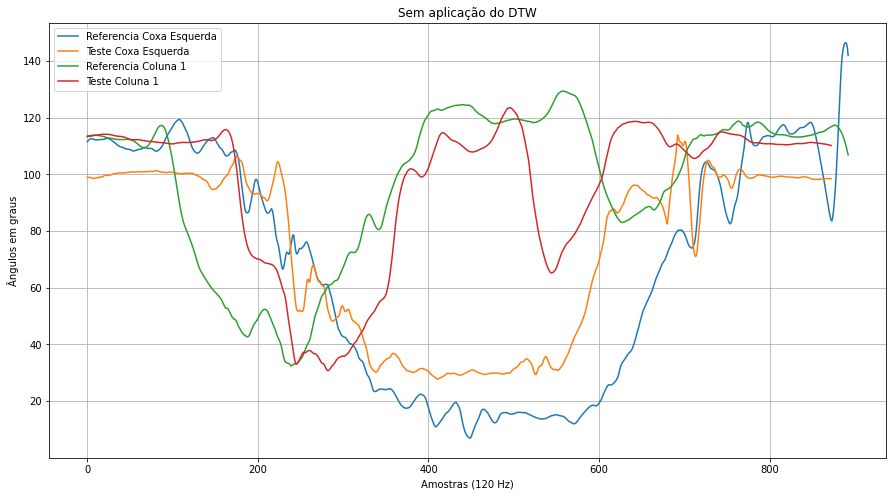

In [116]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean, label = 'Referencia Coxa Esquerda')
plt.plot(angle_left_up_leg_mean, label = 'Teste Coxa Esquerda')
plt.plot(ref_angle_neck_mean, label = 'Referencia Coluna 1')
plt.plot(angle_neck_mean, label = 'Teste Coluna 1')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.title('Sem aplicação do DTW')
plt.grid()
plt.show()

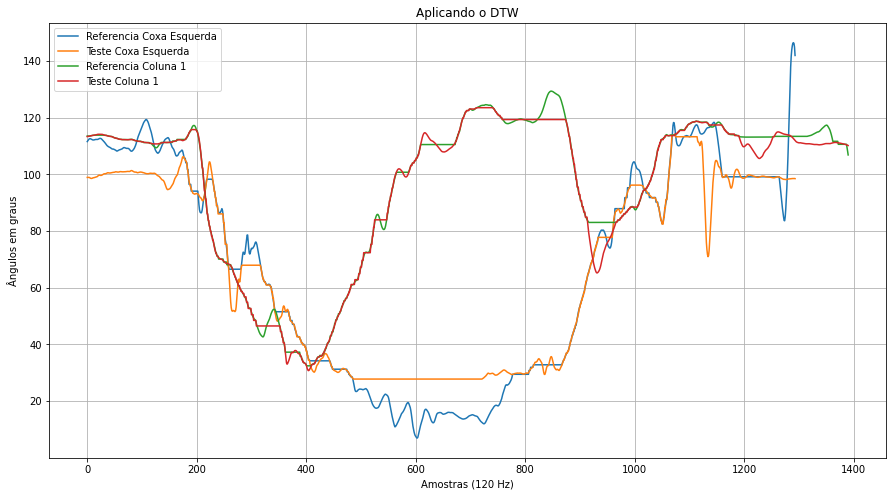

In [117]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean[paths_left_up_leg[:,0]], label = 'Referencia Coxa Esquerda')
plt.plot(angle_left_up_leg_mean[paths_left_up_leg[:,1]], label = 'Teste Coxa Esquerda')
plt.plot(ref_angle_neck_mean[paths_neck[:,0]], label = 'Referencia Coluna 1')
plt.plot(angle_neck_mean[paths_neck[:,1]], label = 'Teste Coluna 1')
#plt.scatter(pose_IMU_ref,)
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.title('Aplicando o DTW')
plt.grid()
plt.show()

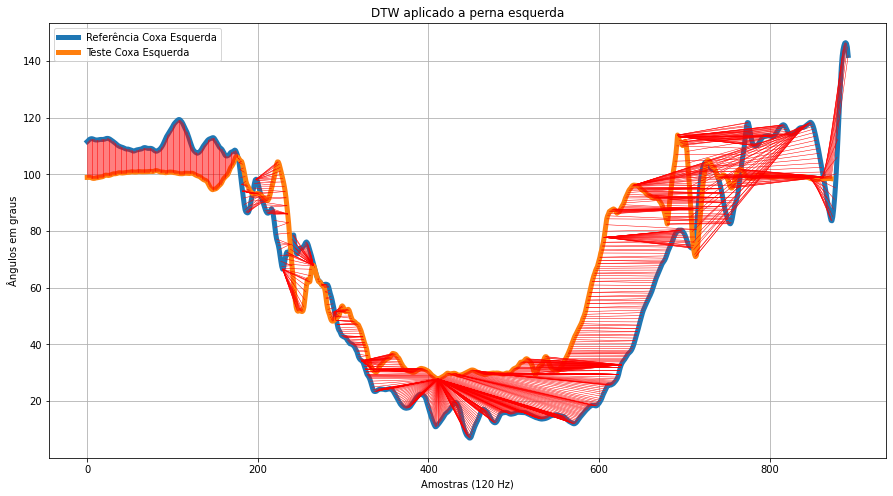

In [118]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean, label = 'Referência Coxa Esquerda', linewidth=5)
plt.plot(angle_left_up_leg_mean, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_left_up_leg[:, 0])):
    plt.plot([paths_left_up_leg[i, 0], paths_left_up_leg[i, 1]], [ref_angle_left_up_leg_mean[paths_left_up_leg[i,0]], 
             angle_left_up_leg_mean[paths_left_up_leg[i,1]]], 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a perna esquerda')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()


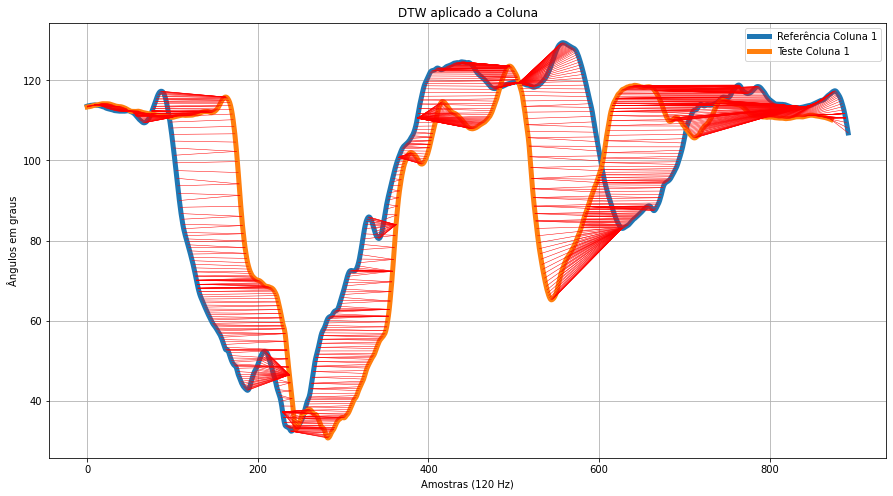

In [167]:
plt.figure(figsize=[15,8])
plt.plot(ref_angle_neck_mean, label = 'Referência Coluna 1', linewidth=5)
plt.plot(angle_neck_mean, label = 'Teste Coluna 1', linewidth=5)

for i in range(len(paths_neck[:, 0])):
    plt.plot([paths_neck[i, 0], paths_neck[i, 1]], [ref_angle_neck_mean[paths_neck[i,0]], 
                                                        angle_neck_mean[paths_neck[i,1]]], 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a Coluna')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a Coluna.png')
plt.show()


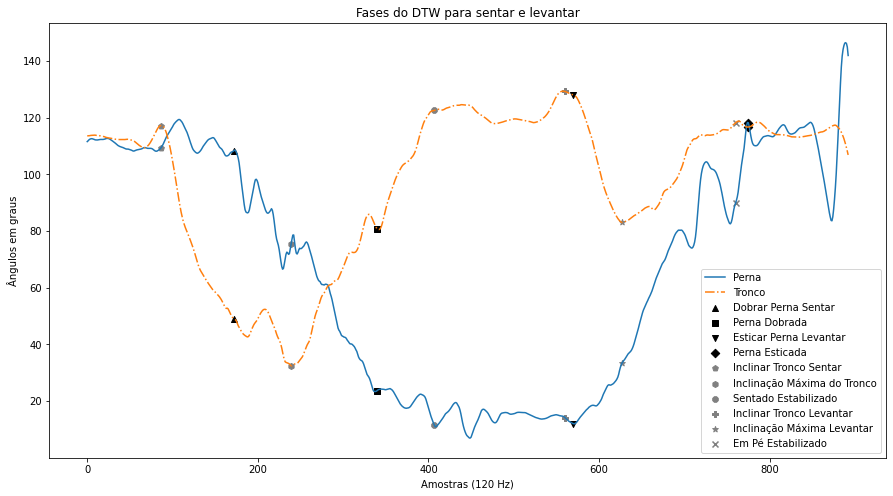

In [229]:
estimated_targets_left_up_leg = [ 172, 340, 570, 775]
estimated_targets_neck = [ 86, 239, 407, 560, 627, 760]


markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_left_up_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_neck = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
#phases_colors = ['black', 'gray', 'red', 'purple', 'yellow', 'green',]


plt.figure(figsize=[15,8])
plt.plot(ref_angle_left_up_leg_mean, label='Perna')
plt.plot(ref_angle_neck_mean, label='Tronco', linestyle='-.')

for i in range(len(estimated_targets_left_up_leg)):    
    plt.scatter(estimated_targets_left_up_leg[i], ref_angle_left_up_leg_mean[estimated_targets_left_up_leg[i]], 
            marker=markers[i], color='black', label=rowing_phases_left_up_leg[i])
    plt.scatter(estimated_targets_left_up_leg[i], ref_angle_neck_mean[estimated_targets_left_up_leg[i]], 
            marker=markers[i], color='black')
    
for i in range(len(estimated_targets_neck)):    
    plt.scatter(estimated_targets_neck[i], ref_angle_left_up_leg_mean[estimated_targets_neck[i]], 
            marker=markers[i+4], color='gray', label=rowing_phases_spine1[i])
    plt.scatter(estimated_targets_neck[i], ref_angle_neck_mean[estimated_targets_neck[i]], 
            marker=markers[i+4], color='gray')

plt.title('Fases do DTW para sentar e levantar')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid(False)
plt.axis(True)
#plt.savefig('Fases do DTW para sentar e levantar.jpeg', format = 'jpeg')
plt.show()


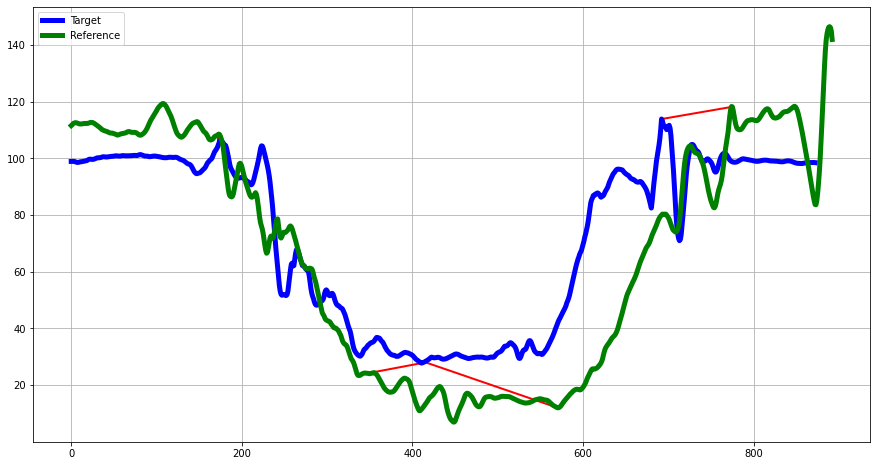

In [230]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_left_up_leg[:, 0])):
    if paths_left_up_leg[i, 0] == estimated_targets_left_up_leg[k]:
        plt.plot([paths_left_up_leg[i, 0], paths_left_up_leg[i, 1]], [ref_angle_left_up_leg_mean[paths_left_up_leg[i,0]], 
                 angle_left_up_leg_mean[paths_left_up_leg[i,1]]], 'r', linewidth=2)
        if paths_left_up_leg[i + 1, 0] == estimated_targets_left_up_leg[k]:
            pass
        else:
            k = k + 1
    if k == 4:
        k = 0
        
plt.plot(angle_left_up_leg_mean, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_left_up_leg_mean, color = 'g',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()


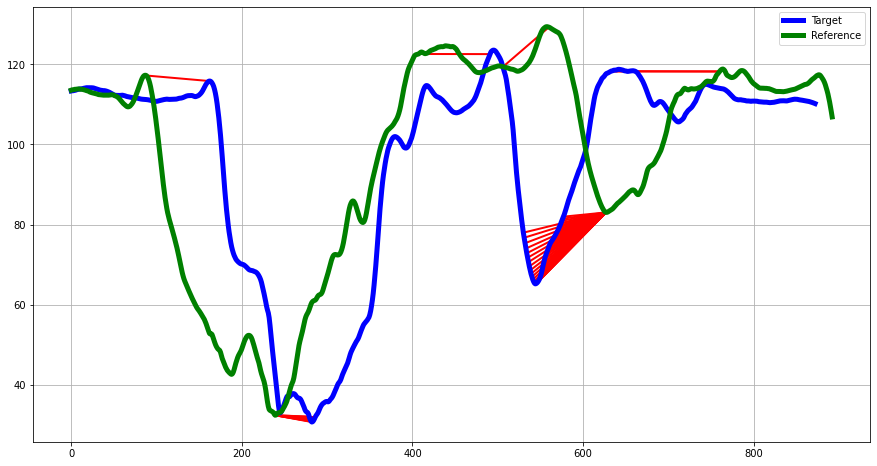

In [231]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_neck[:, 0])):
    if paths_neck[i, 0] == estimated_targets_neck[k]:
        plt.plot([paths_neck[i, 0], paths_neck[i, 1]], [ref_angle_neck_mean[paths_neck[i,0]], 
                 angle_neck_mean[paths_neck[i,1]]], 'r', linewidth=2)
        if paths_neck[i + 1, 0] == estimated_targets_neck[k]:
            pass
        else:
            k = k + 1
    if k == 6:
        k = 0
        
plt.plot(angle_neck_mean, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_neck_mean, color = 'g',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()

Text(0.5, 1.0, 'DTW Distance')

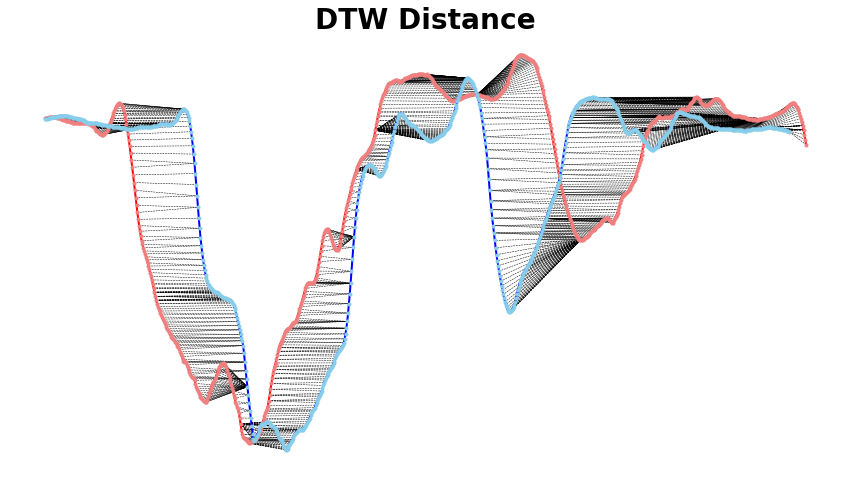

In [232]:
fig, ax = plt.subplots(figsize=(15, 8))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

map_x = paths_neck[:,0]
map_y = paths_neck[:,1]

for [map_x, map_y] in paths_neck:
    ax.plot([map_x, map_y], [ref_angle_neck_mean[map_x], angle_neck_mean[map_y]], '--k', linewidth=0.5)

ax.plot(ref_angle_neck_mean, '-ro', label='x', linewidth=2, markersize=3, markerfacecolor='lightcoral',
        markeredgecolor='lightcoral')
ax.plot(angle_neck_mean, '-bo', label='y', linewidth=2, markersize=3, markerfacecolor='skyblue',
        markeredgecolor='skyblue')
ax.set_title("DTW Distance", fontsize=28, fontweight="bold")
